In [110]:
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy.timeseries import LombScargle
import scipy.signal as signal
import numpy as np
import pandas as pd
%matplotlib inline

In [111]:
# reading data with pandas
# skip data interpretates like NaN
fname='2017-18.dat'
data = pd.read_csv(fname, sep = '\s+', header = None)
data.head()

,0,1
0,0.000,2.09
1,0.042,2.05
2,0.083,NaN
3,0.125,2.12
4,0.167,2.40


In [112]:
# search and remember NaN in data into logical massive mask
print(data[0].astype(float))
maska=(np.isnan(data[1].astype(float)))
for i in range(len(maska)): maska[i]=(not maska[i])
print(len(maska))

0         0.000
1         0.042
2         0.083
3         0.125
4         0.167
         ...   
2899    120.792
2900    120.833
2901    120.875
2902    120.917
2903    120.958
Name: 0, Length: 2904, dtype: float64
2904


In [113]:
# skip NaN in data
time=np.asarray(data[maska][0])
foEs=np.asarray(data[maska][1])
ntime=len(time)
print(foEs)

[2.09 2.05 2.12 ... 2.56 1.48 2.08]


### LS - процедура ко всему ряду

0.008278693953241937 1.000066229551626 600


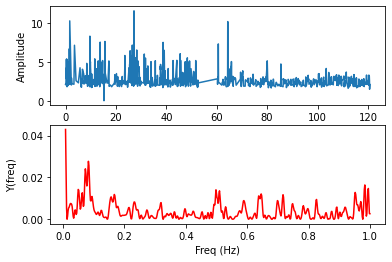

In [114]:
foEsmean=np.nanmean(foEs)
nyquist=1
#freq, Y = LombScargle(time,foEs-foEsmean).autopower(nyquist_factor=nyquist)
# min and max frequensy in 1/day
min_freq=1./time[ntime-1]
max_freq=1.
freq, Y = LombScargle(time,foEs-foEsmean).autopower(minimum_frequency=min_freq,maximum_frequency=max_freq)
fig, ax = plt.subplots(2, 1)
ax[0].plot(time,foEs)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')

ax[1].plot(freq,Y,'r') # plotting the spectrum

ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('Y(freq)')
print(freq.min(),freq.max(),len(freq))

Text(0, 0.5, 'Y')

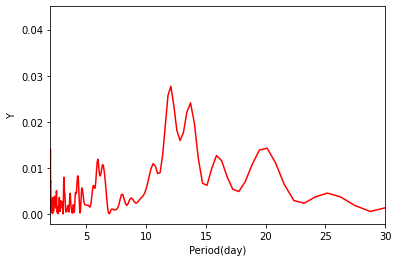

In [115]:
plt.xlim([2.,30.])
plt.plot(1./freq,Y,'r')
plt.xlabel('Period(day)')
plt.ylabel('Y')


### Готовим оконное преобразование

In [116]:
# window size in day
w_size=18.

dx=0.042 # step into win
# number of points in windows

w_num=int(w_size/dx)
# number of time's points
w_frec=len(time)-1

In [117]:
# возможны пропуски в данных, ищем их (вроде после удаленгия NaN не надо, но осталось)
bord=[]
i_st_end=np.zeros(2).astype(int)
jstart=0
jend=0
# search windows
for i in range(0,ntime-w_num-1): # цикл по всем точкам xt
   
    ix_start=i
    ix_end=i+w_num
    x_s=time[ix_start]
    x_e=time[ix_end]
    #print(i,x_s,x_e)
    #print(i_st_end)
    while(x_s > time[jstart]):
        jstart=jstart+1
        jend=jstart
        #print(jstart)
    while (x_e > time[jend]):
        jend=jend+1
        if(jend>w_frec):
            jend=w_frec
            break
         
        
    bord.append([jstart,jend])

In [118]:
w_spectr=len(bord)

minW_freq=1./w_size
maxW_freq=1./0.05
#freq0, Y = LombScargle(time[0:w_size],foEs[0:w_size]).autopower(nyquist_factor=0.1) 
freq0, Y = LombScargle(time[0:w_num],foEs[0:w_num]).autopower(minimum_frequency=minW_freq,maximum_frequency=maxW_freq)

i_df=len(freq0)
print(i_df,len(freq),len(bord))
m_LS=np.zeros(i_df*w_spectr).reshape(i_df,w_spectr)


4247 600 609


In [119]:
# massive of spectrogramm
# window LS transform

i=0
for gran in bord:
    i_st=gran[0]
    i_en=gran[1]
    foEsmean=np.nanmean(foEs[i_st:i_en])
    
    #freq, m_LS[0:i_df,i] = LombScargle(time[i_st:i_en],foEs[i_st:i_en]).autopower(minimum_frequency=minW_freq,maximum_frequency=maxW_freq)
    #freq, S = LombScargle(time[i_st:i_en],foEs[i_st:i_en]).autopower(minimum_frequency=minW_freq,maximum_frequency=maxW_freq)
    #print(len(S),np.max(freq),np.min(freq))
    m_LS[0:i_df,i] = LombScargle(time[i_st:i_en],foEs[i_st:i_en]-foEsmean).power(freq0)
    #plt.plot(freq,S)
    i=i+1
        
print (np.shape(m_LS),np.shape(freq))         
        

(4247, 609) (600,)


609 609 4247 600


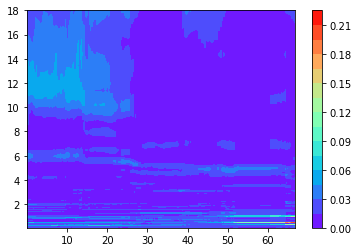

In [120]:
print(len(time[:-w_num-1]),len(m_LS[0,:]),len(m_LS[:,0]),len(freq))
#lev=np.arange(8,16,2)
#lev=np.linspace(0.01,0.3,20)
plt.contourf(time[1:-w_num-1],1./freq0,m_LS[:,1:],levels=20,cmap=cm.rainbow)

plt.colorbar()
plt.savefig("LS_foEs"+str(w_size).format("6.2f")+".png")